In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
print(tf.__version__)

1.6.0


# 0 数据准备

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# 1 构建模型

这一部分我们将通过构建一个网络，并探究BN在网络中的作用。

In [41]:
class NeuralNetWork():
    def __init__(self, initial_weights, activation_fn, use_batch_norm):
        """
        初始化网络对象
        :param initial_weights: 权重初始化值，是一个list，list中每一个元素是一个权重矩阵
        :param activation_fn: 隐层激活函数
        :param user_batch_norm: 是否使用batch normalization
        """
        self.use_batch_norm = use_batch_norm
        self.name = "With Batch Norm" if use_batch_norm else "Without Batch Norm"
        
        self.is_training = tf.placeholder(tf.bool, name='is_training')
        
        # 存储训练准确率
        self.training_accuracies = []
        
        self.build_network(initial_weights, activation_fn)
        
    def build_network(self, initial_weights, activation_fn):
        """
        构建网络图
        :param initial_weights: 权重初始化，是一个list
        :param activation_fn: 隐层激活函数
        """
        self.input_layer = tf.placeholder(tf.float32, [None, initial_weights[0].shape[0]])
        layer_in = self.input_layer
        
        # 前向计算（不计算最后输出层）
        for layer_weights in initial_weights[:-1]:
            layer_in = self.fully_connected(layer_in, layer_weights, activation_fn)
            
        # 输出层
        self.output_layer = self.fully_connected(layer_in, initial_weights[-1])
    
    def fully_connected(self, layer_in, layer_weights, activation_fn=None):
        """
        抽象出的全连接层计算
        """
        # 如果使用BN与激活函数
        if self.use_batch_norm and activation_fn:
            weights = tf.Variable(layer_weights)
            linear_output = tf.matmul(layer_in, weights)
            
            # 调用BN接口
            batch_normalized_output = tf.layers.batch_normalization(linear_output, training=self.is_training)

            return activation_fn(batch_normalized_output)
        # 如果不使用BN或激活函数（即普通隐层） 
        else:
            weights = tf.Variable(layer_weights)
            bias = tf.Variable(tf.zeros([layer_weights.shape[-1]]))
            linear_output = tf.add(tf.matmul(layer_in, weights), bias)

            return activation_fn(linear_output) if activation_fn else linear_output
    
    def train(self, sess, learning_rate, training_batches, batches_per_validate_data, save_model=None):
        """
        训练模型
        :param sess: TensorFlow Session
        :param learning_rate: 学习率
        :param training_batches: 用于训练的batch数
        :param batches_per_validate_data: 训练多少个batch对validation数据进行一次验证
        :param save_model: 存储模型
        """
        
        # 定义输出label
        labels = tf.placeholder(tf.float32, [None, 10])
        
        # 定义损失函数
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, 
                                                                                  logits=self.output_layer))
        
        # 准确率
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        #
        if self.use_batch_norm:
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
            
        else:
            train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        
        # 显示进度条
        for i in tqdm.tqdm(range(training_batches)):
            batch_x, batch_y = mnist.train.next_batch(60)
            sess.run(train_step, feed_dict={self.input_layer: batch_x,
                                            labels: batch_y,
                                            self.is_training: True})
            if i % batches_per_validate_data == 0:
                val_accuracy = sess.run(accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                                              labels: mnist.validation.labels,
                                                              self.is_training: False})
                self.training_accuracies.append(val_accuracy)
        print("{}: The final accuracy on validation data is {}".format(self.name, val_accuracy))
        
        # 存储模型
        if save_model:
            tf.train.Saver().save(sess, save_model)
    
    def test(self, sess, test_training_accuracy=False, restore=None):
        # 定义label
        labels = tf.placeholder(tf.float32, [None, 10])
        
        # 准确率
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        # 是否加载模型
        if restore:
            tf.train.Saver().restore(sess, restore)
        
        test_accuracy = sess.run(accuracy, feed_dict={self.input_layer: mnist.test.images,
                                                      labels: mnist.test.labels,
                                                      self.is_training: False})
        
        print("{}: The final accuracy on test data is {}".format(self.name, test_accuracy))
        

# 2 辅助函数

辅助函数主要包括两个：
- 绘制训练过程的准确率
- 测试有BN与没有BN

In [42]:
def plot_training_accuracies(*args, batches_per_validate_data):
    """
    绘制模型在训练过程中的准确率曲线
    
    :param args: 一个或多个NeuralNetWork对象
    :param batches_per_validate_data: 训练多少个batch进行一次数据验证
    """
    fig, ax = plt.subplots()
    
    for nn in args:
        ax.plot(range(0, len(nn.training_accuracies)*batches_per_validate_data, batches_per_validate_data),
                nn.training_accuracies, label=nn.name)
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Validation Accuracy During Training')
    ax.legend(loc=4)
    ax.set_ylim([0,1])
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.show()

def train_and_test(use_larger_weights, learning_rate, activation_fn, training_batches=50000, batches_per_validate_data=500):
    """
    使用相同的权重初始化生成两个网络对象，其中一个使用BN，另一个不使用BN
    
    :param use_larger_weights: 是否使用更大的权重
    :param learning_rate: 学习率
    :param activation_fn: 激活函数
    :param training_batches: 训练阶段使用的batch数（默认为50000）
    :param batches_per_validate_data: 训练多少个batch后在validation数据上进行测试
    """
    if use_larger_weights:
        weights = [np.random.normal(size=(784,128), scale=10.0).astype(np.float32),
                   np.random.normal(size=(128,128), scale=10.0).astype(np.float32),
                   np.random.normal(size=(128,128), scale=10.0).astype(np.float32),
                   np.random.normal(size=(128,10), scale=10.0).astype(np.float32)
                  ]
    else:
        weights = [np.random.normal(size=(784,128), scale=0.05).astype(np.float32),
                   np.random.normal(size=(128,128), scale=0.05).astype(np.float32),
                   np.random.normal(size=(128,128), scale=0.05).astype(np.float32),
                   np.random.normal(size=(128,10), scale=0.05).astype(np.float32)
                  ]

    tf.reset_default_graph()

    nn = NeuralNetWork(weights, activation_fn, use_batch_norm=False) # Without BN
    bn = NeuralNetWork(weights, activation_fn, use_batch_norm=True) # With BN
    
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        
        print("【Training Result:】\n")
        
        nn.train(sess, learning_rate, training_batches, batches_per_validate_data)
        bn.train(sess, learning_rate, training_batches, batches_per_validate_data)
        
        print("\n【Testing Result:】\n")
        nn.test(sess)
        bn.test(sess)
    
    plot_training_accuracies(nn, bn, batches_per_validate_data=batches_per_validate_data)


# 3 BN测试

完成了前面的准备工作，我们接下来就可以对BN的情况进行测试，测试内容主要为：

- 使用较小的Weights初始化，较小学习率，relu激活函数
- 使用较小的Weights初始化，较小学习率，sigmoid激活函数
- 使用较小的Weights初始化，较大学习率，relu激活函数
- 使用较小的Weights初始化，较大学习率，sigmoid激活函数
- 使用较大的Weights初始化，较小学习率，relu激活函数
- 使用较大的Weights初始化，较小学习率，sigmoid激活函数
- 使用较大的Weights初始化，较大学习率，relu激活函数
- 使用较大的Weights初始化，较大学习率，sigmoid激活函数

## 3.1 较小的Weights初始化，较小学习率，relu激活函数

  0%|          | 0/50000 [00:00<?, ?it/s]

【Training Result:】



100%|██████████| 50000/50000 [01:43<00:00, 483.61it/s]


Without Batch Norm: The final accuracy on validation data is 0.977400004863739


100%|██████████| 50000/50000 [02:31<00:00, 329.23it/s]


With Batch Norm: The final accuracy on validation data is 0.9800000190734863

【Testing Result:】

Without Batch Norm: The final accuracy on test data is 0.9746000170707703
With Batch Norm: The final accuracy on test data is 0.9800999760627747


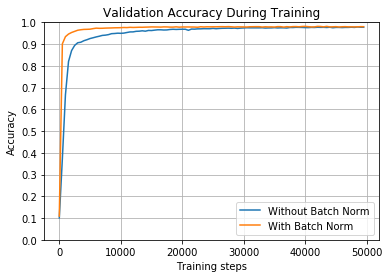

In [43]:
train_and_test(use_larger_weights=False, learning_rate=0.01, activation_fn=tf.nn.relu)

<font face='黑体' color='#00008B'> 我们可以看到无论是在validation数据集上，还是在test数据集上，加入BN的网络效果都会略优于没有BN的网络。其次，可以看到加入BN的训练速度会变慢（329.23it/s）。另外我们可以看到加入BN的网络收敛的更快，其更早地达到了较高地准确率。为了更清晰地看到收敛速度快慢，我们调小training batches参数。

  0%|          | 13/3000 [00:00<00:23, 127.99it/s]

【Training Result:】



100%|██████████| 3000/3000 [00:06<00:00, 429.97it/s]


Without Batch Norm: The final accuracy on validation data is 0.8934000134468079


100%|██████████| 3000/3000 [00:11<00:00, 265.27it/s]


With Batch Norm: The final accuracy on validation data is 0.9652000069618225

【Testing Result:】

Without Batch Norm: The final accuracy on test data is 0.8906000256538391
With Batch Norm: The final accuracy on test data is 0.9596999883651733


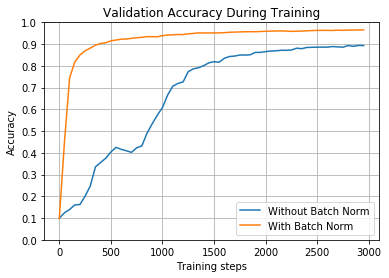

In [44]:
train_and_test(use_larger_weights=False, learning_rate=0.01, activation_fn=tf.nn.relu, training_batches=3000, batches_per_validate_data=50)

<font face='黑体' color='#00008B'> 从上图中我们就可以清晰看到，加入BN的网络在第500个batch的时候已经能够在validation数据集上达到90%的准确率；而没有BN的网络的准确率还在不停波动，并且到第3000个batch的时候才达到90%的准确率。

## 3.2 较小的Weights初始化，较小学习率，sigmoid激活函数

  0%|          | 0/50000 [00:00<?, ?it/s]

【Training Result:】



100%|██████████| 50000/50000 [01:44<00:00, 480.48it/s]


Without Batch Norm: The final accuracy on validation data is 0.8615999817848206


100%|██████████| 50000/50000 [02:28<00:00, 335.98it/s]


With Batch Norm: The final accuracy on validation data is 0.9746000170707703

【Testing Result:】

Without Batch Norm: The final accuracy on test data is 0.8569999933242798
With Batch Norm: The final accuracy on test data is 0.9700000286102295


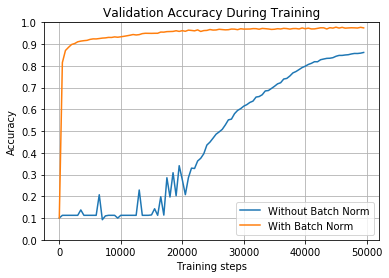

In [46]:
train_and_test(use_larger_weights=False, learning_rate=0.01, activation_fn=tf.nn.sigmoid)

<font face='黑体' color='#00008B'> 在上面的图中，我们将隐层激活函数换成了sigmoid，可以发现加入BN以后的网络同样在很短的次数内就开始收敛，而没有BN的网络前期一直在发生震荡，随着训练的进行开始逐渐稳定，但最终的模型效果却和加入BN的网络相差甚远。

## 3.3 较小的Weights初始化，较大学习率，relu激活函数

  0%|          | 0/50000 [00:00<?, ?it/s]

【Training Result:】



100%|██████████| 50000/50000 [01:43<00:00, 481.45it/s]


Without Batch Norm: The final accuracy on validation data is 0.11259999871253967


100%|██████████| 50000/50000 [02:34<00:00, 323.11it/s]


With Batch Norm: The final accuracy on validation data is 0.9846000075340271

【Testing Result:】

Without Batch Norm: The final accuracy on test data is 0.0982000008225441
With Batch Norm: The final accuracy on test data is 0.9804999828338623


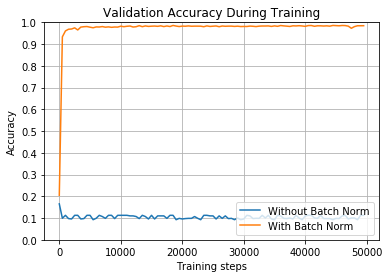

In [47]:
train_and_test(use_larger_weights=False, learning_rate=2, activation_fn=tf.nn.relu)

<font face='黑体' color='#00008B'> 在本次实验中，我们使用了较大的学习率，较大的学习率意味着权重的更新跨度很大，而根据我们前面理论部分的介绍，BN不会受到权重scale的影响，因此其能够使模型保持在一个稳定的训练状态；而没有加入BN的网络则在一开始就由于学习率过大导致训练失败。

## 3.4 较小的Weights初始化，较大学习率，sigmoid激活函数

  0%|          | 15/50000 [00:00<05:37, 147.92it/s]

【Training Result:】



100%|██████████| 50000/50000 [01:27<00:00, 574.69it/s]


Without Batch Norm: The final accuracy on validation data is 0.9811999797821045


100%|██████████| 50000/50000 [02:33<00:00, 325.62it/s]


With Batch Norm: The final accuracy on validation data is 0.9829999804496765

【Testing Result:】

Without Batch Norm: The final accuracy on test data is 0.9783999919891357
With Batch Norm: The final accuracy on test data is 0.9801999926567078


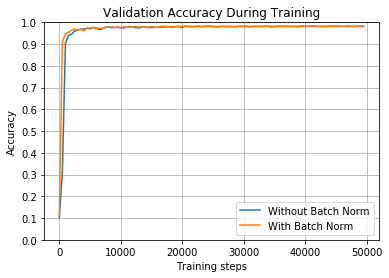

In [48]:
train_and_test(use_larger_weights=False, learning_rate=2, activation_fn=tf.nn.sigmoid)

<font face='黑体' color='#00008B'> 在保持较大学习率（learning rate=2）的情况下，当我们将激活函数换为sigmoid以后，两个模型都能够达到一个很好的效果，并且在test数据及上的准确率非常接近；但加入BN的网络要收敛地更快，同样的，我们来观察3000次batch的训练准确率。

  1%|          | 20/3000 [00:00<00:14, 199.76it/s]

【Training Result:】



100%|██████████| 3000/3000 [00:06<00:00, 433.74it/s]


Without Batch Norm: The final accuracy on validation data is 0.9657999873161316


100%|██████████| 3000/3000 [00:11<00:00, 261.68it/s]


With Batch Norm: The final accuracy on validation data is 0.9700000286102295

【Testing Result:】

Without Batch Norm: The final accuracy on test data is 0.9606000185012817
With Batch Norm: The final accuracy on test data is 0.9631999731063843


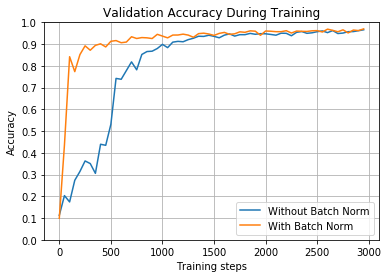

In [49]:
train_and_test(use_larger_weights=False, learning_rate=2, activation_fn=tf.nn.sigmoid, training_batches=3000, batches_per_validate_data=50)

<font face='黑体' color='#0008B'> 当我们把training batch限制到3000以后，可以发现加入BN后，尽管我们使用较大的学习率，其仍然能够在大约500个batch以后在validation上达到90%的准确率；但不加入BN的准确率前期在一直大幅度波动，到大约1200个batch以后才达到90%的准确率。

## 3.5 较大的Weights初始化，较小学习率，relu激活函数

  0%|          | 8/50000 [00:00<10:33, 78.97it/s]

【Training Result:】



100%|██████████| 50000/50000 [01:31<00:00, 544.76it/s]


Without Batch Norm: The final accuracy on validation data is 0.0957999974489212


100%|██████████| 50000/50000 [02:20<00:00, 356.07it/s]


With Batch Norm: The final accuracy on validation data is 0.7802000045776367

【Testing Result:】

Without Batch Norm: The final accuracy on test data is 0.09799999743700027
With Batch Norm: The final accuracy on test data is 0.7728000283241272


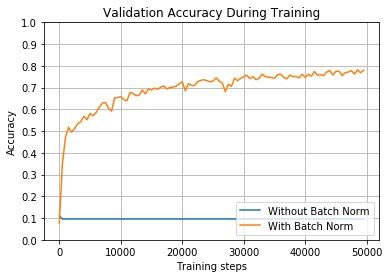

In [50]:
train_and_test(use_larger_weights=True, learning_rate=0.01, activation_fn=tf.nn.relu)

<font face='黑体' color='#0008B'> 当我们使用较大权重时，不加入BN的网络在一开始就失效；而加入BN的网络能够克服如此bad的权重初始化，并达到接近80%的准确率。

## 3.6 较大的Weights初始化，较小学习率，sigmoid激活函数

  0%|          | 8/50000 [00:00<10:35, 78.61it/s]

【Training Result:】



100%|██████████| 50000/50000 [01:42<00:00, 489.51it/s]


Without Batch Norm: The final accuracy on validation data is 0.2919999957084656


100%|██████████| 50000/50000 [02:38<00:00, 314.49it/s]


With Batch Norm: The final accuracy on validation data is 0.8569999933242798

【Testing Result:】

Without Batch Norm: The final accuracy on test data is 0.2897000014781952
With Batch Norm: The final accuracy on test data is 0.8496000170707703


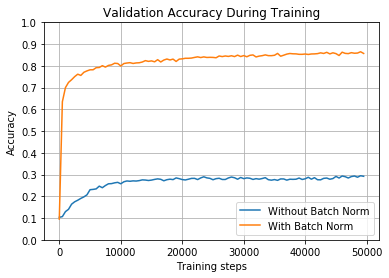

In [51]:
train_and_test(use_larger_weights=True, learning_rate=0.01, activation_fn=tf.nn.sigmoid)

<font face='黑体' color='#0008B'> 同样使用较大的权重初始化，当我们激活函数为sigmoid时，不加入BN的网络在一开始的准确率有所上升，但随着训练的进行网络逐渐失效；而加入BN的网络依旧出色地克服如此bad的权重初始化，并达到接近85%的准确率。

## 3.7 较大的Weights初始化，较大学习率，relu激活函数

  0%|          | 18/50000 [00:00<04:38, 179.44it/s]

【Training Result:】



100%|██████████| 50000/50000 [01:38<00:00, 507.39it/s]


Without Batch Norm: The final accuracy on validation data is 0.0957999974489212


100%|██████████| 50000/50000 [02:32<00:00, 327.77it/s]


With Batch Norm: The final accuracy on validation data is 0.10999999940395355

【Testing Result:】

Without Batch Norm: The final accuracy on test data is 0.09799999743700027
With Batch Norm: The final accuracy on test data is 0.09740000218153


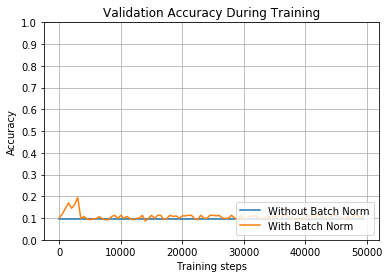

In [52]:
train_and_test(use_larger_weights=True, learning_rate=2, activation_fn=tf.nn.relu)

<font face='黑体' color='#00008B'> 当权重与学习率都很大时，BN网络开始还会训练一段时间，但随后就直接停止训练；而没有BN的网络开始模型就失效。

## 3.8 较大的Weights初始化，较大学习率，sigmoid激活函数

  0%|          | 0/50000 [00:00<?, ?it/s]

【Training Result:】



100%|██████████| 50000/50000 [01:41<00:00, 494.57it/s]


Without Batch Norm: The final accuracy on validation data is 0.0868000015616417


100%|██████████| 50000/50000 [02:32<00:00, 328.44it/s]


With Batch Norm: The final accuracy on validation data is 0.9387999773025513

【Testing Result:】

Without Batch Norm: The final accuracy on test data is 0.09799999743700027
With Batch Norm: The final accuracy on test data is 0.9354000091552734


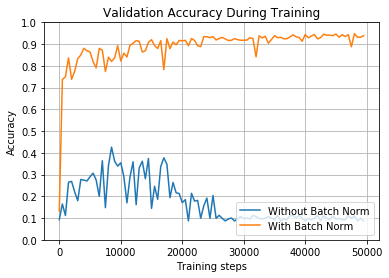

In [53]:
train_and_test(use_larger_weights=True, learning_rate=2, activation_fn=tf.nn.sigmoid)

<font face='黑体' color='#0008B'> 可以看到，加入BN对较大的权重与较大学习率都具有非常好的鲁棒性，最终模型能够达到93%的准确率；而未加入BN的网络则经过一段时间震荡后开始失效。